In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import nltk
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer, PorterStemmer
# from nltk.corpus import wordnet
# nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
# lemmatizer = WordNetLemmatizer()
# stemmer = PorterStemmer()

# # Function to get POS tag
# def get_wordnet_pos(word):
#     tag = nltk.pos_tag([word])[0][1][0].upper()
#     tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
#     return tag_dict.get(tag, wordnet.NOUN)

# function to tokenize text
def tokenize(text):
    tokens = [
        token.lower()
        for token in text.split()
        if token.lower() not in stop_words and token.isalpha()
    ]
    return ' '.join(tokens)
    # tokens = []
    # for token in text.split():
    #     if token.lower() not in stop_words and token.isalpha():
    #         # token = lemmatizer.lemmatize(token, get_wordnet_pos(token))
    #         # token = stemmer.stem(token)
    #         tokens.append(token.lower())
    # return tokens

In [3]:
# data

# read in literature data
data = pd.read_csv('data/TAB_binaryLabel.csv')

# preprocess (lower, remove stopwords and punct)
data['TAB_preproc'] = data["TAB"].apply(tokenize)

# train test split
from sklearn.model_selection import train_test_split
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(data['TAB_preproc'], data['label'], test_size=0.2, random_state=2025)
X_train, X_test, y_train, y_test = train_test_split(data['TAB_preproc'], data['label'], test_size=0.2, random_state=2025)

data.head()

,label,TAB,TAB_preproc
0,1,Timber-Yielding Plants of the Tamaulipan Thorn...,plants tamaulipan thorn bioenergy potential cu...
1,1,Restoration: Success and Completion Criteria R...,success completion criteria restoration distur...
2,1,Soil Carbon Sequestration: Ethiopia Sequestrat...,soil carbon ethiopia sequestration soil organi...
3,1,Village Bamboos It has been recognized that ba...,village bamboos recognized bamboos growing wil...
4,1,Physical protection by soil aggregates stabili...,physical protection soil aggregates stabilizes...


## Vectorizations

### TF-IDF

In [14]:
# TF-IDF preprocessing tab text
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
# Transform the text data to feature vectors
X = vectorizer.fit_transform(data['TAB_preproc'])
# Labels
y = data['label']

# split data
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X, y, test_size=0.2, stratify=data["label"], random_state=2025)

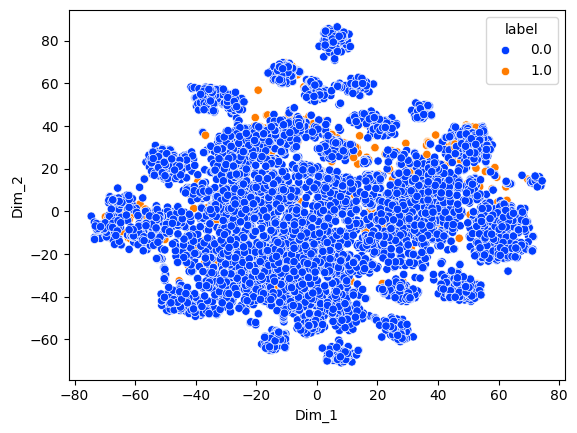

In [ ]:
# Visualize TF-IDF clusters with TSNE (will crash if run twice)

# Reduce dimensions from 10550 to 50 with TruncatedSVD
from sklearn.decomposition import TruncatedSVD 
truncatedSVD=TruncatedSVD(50)
X_truncated = truncatedSVD.fit_transform(X)

# Compute TSNEs
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
model = TSNE(n_components = 2, random_state = 2025)
tsne_data = model.fit_transform(X_truncated)
tsne_data = np.vstack((tsne_data.T, data['label'])).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))

# Free memory
import gc
del X_truncated
del truncatedSVD
gc.collect()

# Plot TSNEs
sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2', hue='label', palette="bright")
plt.show()

### Word2Vec

https://www.youtube.com/watch?v=Q2NtCcqmIww
https://spotintelligence.com/2023/02/15/word2vec-for-text-classification/


In [37]:
import gensim

In [38]:
X_train_preproc = X_train_og.apply(gensim.utils.simple_preprocess)
X_test_preproc = X_test_og.apply(gensim.utils.simple_preprocess)

In [ ]:
# init and train w2v model

w2v_model = gensim.models.Word2Vec(
    window=10,
    min_count=2,
    workers=4
)
w2v_model.build_vocab(X_train_og.str.split()) #X_train_preproc
w2v_model.epochs = 6
w2v_model.train(X_train_og.str.split(), total_examples=w2v_model.corpus_count, epochs=w2v_model.epochs) #X_train_preproc

(6122012, 6539700)

In [46]:
w2v_model.wv.most_similar("agroforestry")

[('systems', 0.9087960124015808),
 ('cocoa', 0.7796108722686768),
 ('silvopastoral', 0.7745179533958435),
 ('rustic', 0.7209551334381104),
 ('system', 0.7207581400871277),
 ('coffee', 0.7154161930084229),
 ('cropping', 0.7138540148735046),
 ('agroforests', 0.6932270526885986),
 ('cacao', 0.6803526878356934),
 ('farms', 0.6792547106742859)]

In [51]:
import numpy as np

def vectorize(sentence):
    # words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in sentence if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)


X_train_w2v = np.array([vectorize(sentence) for sentence in X_train_og.str.split()])
X_test_w2v = np.array([vectorize(sentence) for sentence in X_test_og.str.split()])

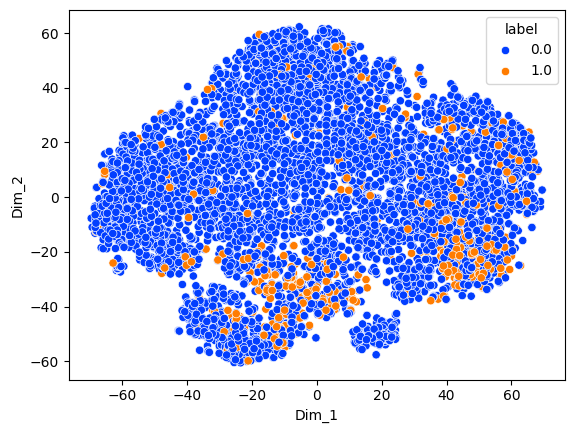

In [ ]:
# Visualize TF-IDF clusters with TSNE (will crash if run twice)

# Reduce dimensions from 10550 to 50 with TruncatedSVD
from sklearn.decomposition import TruncatedSVD 
truncatedSVD=TruncatedSVD(50)
X_truncated = truncatedSVD.fit_transform(X_train)

# Compute TSNEs
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
model = TSNE(n_components = 2, random_state = 2025)
tsne_data = model.fit_transform(X_truncated)
tsne_data = np.vstack((tsne_data.T, y_train)).T
tsne_df = pd.DataFrame(data = tsne_data,
     columns =("Dim_1", "Dim_2", "label"))

# Free memory
import gc
del X_truncated
del truncatedSVD
gc.collect()

# Plot TSNEs
sn.scatterplot(data=tsne_df, x='Dim_1', y='Dim_2', hue='label', palette="bright")
plt.show()

### GloVe

In [163]:
import gensim.downloader

glove_model = gensim.downloader.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [192]:
# glove_model["model"]
glove_model.most_similar("ground")

[('over', 0.6803959012031555),
 ('fire', 0.6762129068374634),
 ('down', 0.6612321734428406),
 ('field', 0.6605717539787292),
 ('area', 0.6582714915275574),
 ('side', 0.6556889414787292),
 ('place', 0.6538392305374146),
 ('well', 0.6529026627540588),
 ('on', 0.650915265083313),
 ('off', 0.6500231623649597)]

In [172]:
X_train_og

2997    Response of soil organic carbon and nitrogen t...
7296    Tree diversity and stored carbon in cocoa (The...
7665    Carbon Dioxide and Methane Emissions from Peat...
5366    Postfire evaluation of fuelwood loss and resto...
2508    Conservation and relative habitat suitability ...
                              ...                        
5331    Native and invasive inoculation sources modify...
323     Preliminary Investigation of the Relationship ...
7672    Determining a Carbon Reference Level for a Hig...
2910    Application of Analog Forestry in salinized so...
6718    The effectiveness of lidar remote sensing for ...
Name: TAB, Length: 6180, dtype: object

In [173]:
def glove_vectorize(sentence):
    # words = sentence.split()
    words_vecs = [glove_model[word] for word in sentence if word in glove_model]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)


X_train_glove = np.array([glove_vectorize(sentence) for sentence in X_train_og])
X_test_glove = np.array([glove_vectorize(sentence) for sentence in X_test_og])

In [ ]:
# preprocess TAB data

# make my_vocab (important >1k words from TAB data)

# fine tune glove with my vocab with mittens

In [5]:
from nltk.corpus import stopwords
sw = stopwords.words('english')
X_train_nonstop = [token.lower() for sentence in X_train_og for token in sentence.split() if (token.lower() not in sw)]

len(X_train_nonstop)

1130379

In [ ]:
import csv
import numpy as np
from collections import Counter
from nltk.corpus import brown
from mittens import GloVe, Mittens
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
import pickle

def glove2dict(glove_filename):
    with open(glove_filename, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:])))
                for line in reader}
    return embed

glove_path = "glove.6B/glove.6B.50d.txt" # get it from https://nlp.stanford.edu/projects/glove
pre_glove = glove2dict(glove_path)

# nltk.download('stopwords')
sw = stopwords.words('english')
# brown_data = brown.words()[:200000]
# vocab = {word for phrase in data['tab_proc'] for word in phrase}
X_train_preproc = X_train_og.apply(gensim.utils.simple_preprocess)

X_train_nonstop = [token.lower() for sentence in X_train_preproc for token in sentence.split() if (token.lower() not in sw)]
oov = [token for token in X_train_nonstop if token not in pre_glove.keys()]

def get_rareoov(xdict, val):
    return [k for (k,v) in Counter(xdict).items() if v<=val]

oov_rare = get_rareoov(oov, 100)
corp_vocab = list(set(oov) - set(oov_rare))

In [26]:
import gensim
X_train_preproc = X_train_og.apply(gensim.utils.simple_preprocess)

X_train_nonstop = [token.lower() for sentence in X_train_preproc for token in sentence if (token.lower() not in sw)]
oov = [token for token in X_train_nonstop if token not in pre_glove.keys()]

In [29]:
len(oov)

24699

In [30]:
def get_rareoov(xdict, val):
    return [k for (k,v) in Counter(xdict).items() if v<=val]

oov_rare = get_rareoov(oov, 100)
corp_vocab = list(set(oov) - set(oov_rare))

In [32]:
corp_vocab

['ndvi',
 'mangium',
 'belowground',
 'wue',
 'chronosequence',
 'litterfall',
 'cunninghamia',
 'massoniana',
 'lulc',
 'rmse',
 'agroforests']

In [33]:
X_train_tokens = [token for token in X_train_nonstop if token not in oov_rare]
X_train_doc = [' '.join(X_train_tokens)]

# corp_vocab = list(set(oov))
# X_train_doc = [' '.join(X_train_nonstop)]

cv = CountVectorizer(ngram_range=(1,1), vocabulary=corp_vocab)
X = cv.fit_transform(X_train_doc)
Xc = (X.T * X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

In [41]:
coocc_ar

array([[    0, 17544, 54008, 18060, 52632, 49192, 19608, 33368, 20296,
        30272, 17544],
       [17544,     0, 32028, 10710, 31212, 29172, 11628, 19788, 12036,
        17952, 10404],
       [54008, 32028,     0, 32970, 96084, 89804, 35796, 60916, 37052,
        55264, 32028],
       [18060, 10710, 32970,     0, 32130, 30030, 11970, 20370, 12390,
        18480, 10710],
       [52632, 31212, 96084, 32130,     0, 87516, 34884, 59364, 36108,
        53856, 31212],
       [49192, 29172, 89804, 30030, 87516,     0, 32604, 55484, 33748,
        50336, 29172],
       [19608, 11628, 35796, 11970, 34884, 32604,     0, 22116, 13452,
        20064, 11628],
       [33368, 19788, 60916, 20370, 59364, 55484, 22116,     0, 22892,
        34144, 19788],
       [20296, 12036, 37052, 12390, 36108, 33748, 13452, 22892,     0,
        20768, 12036],
       [30272, 17952, 55264, 18480, 53856, 50336, 20064, 34144, 20768,
            0, 17952],
       [17544, 10404, 32028, 10710, 31212, 29172, 11628, 197

In [ ]:

mittens_model = Mittens(n=50, max_iter=10000)

new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=corp_vocab,
    initial_embedding_dict= pre_glove)

newglove = dict(zip(corp_vocab, new_embeddings))
f = open("repo_glove.pkl","wb")
pickle.dump(newglove, f)
f.close()

Iteration 10000: error 0.0000

### GloVe 2

In [ ]:
# preprocess TABS, each TAB is processed into a list of words from that doc
from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))
def tokenize(text):
    tokens = [
        token.lower()
        for token in text.split()
        if token.lower() not in stop_words and token.isalpha()
    ]
    return tokens

X_train_preproc = X_train_og.apply(tokenize)
X_train_preproc # series of lists of words that are preprocessed

In [64]:
# use tfidf to extract most important words for each class

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Split your training data by class
class_0_token_lists = X_train_preproc[y_train == 0]
class_1_token_lists = X_train_preproc[y_train == 1]

# Optional: preprocess (join tokens, remove stopwords, etc.)
class_0_corpus = [' '.join(tokens) for tokens in class_0_token_lists]
class_1_corpus = [' '.join(tokens) for tokens in class_1_token_lists]

# Fit TF-IDF vectorizer on both classes independently
tfidf_0 = TfidfVectorizer(max_df=0.90, min_df=3)
tfidf_1 = TfidfVectorizer(max_df=0.90, min_df=3)

X0 = tfidf_0.fit_transform(class_0_corpus)
X1 = tfidf_1.fit_transform(class_1_corpus)

# Get top words by average TF-IDF per class
def top_k_words(tfidf_vec, X, k):
    feature_names = np.array(tfidf_vec.get_feature_names_out())
    avg_scores = X.mean(axis=0).A1
    top_idx = avg_scores.argsort()[::-1][:k]
    return set(feature_names[top_idx])

# Choose number of top words per class
k = 250
top_words_0 = top_k_words(tfidf_0, X0, k)
top_words_1 = top_k_words(tfidf_1, X1, k)

# Combine both
my_vocab = sorted(top_words_0.union(top_words_1))
my_vocab[:10]

['abandoned',
 'aboveground',
 'abundance',
 'acacia',
 'accumulation',
 'across',
 'activities',
 'activity',
 'addition',
 'affected']

In [ ]:
# get all tokens from corpus, Tokenize and clean your training documents
# all_tokens is a list of every word in your corpus
all_tokens = [
    token.lower()
    for sentence in X_train_og  # assuming this is a list/Series of strings
    for token in sentence.split()
    if token.lower() not in stop_words and token.isalpha()
] # len 870493

filtered_all_tokens = [token for token in all_tokens if token in my_vocab] # len 383871


In [80]:
doc = [' '.join(filtered_all_tokens)]
doc[0][:100]

'response soil organic carbon nitrogen nitrogen plantation plant growth ecosystem production nitrogen'

In [81]:
cv = CountVectorizer(vocabulary=my_vocab)
X = cv.fit_transform(doc)
Xc = (X.T @ X)
Xc.setdiag(0)
coocc_ar = Xc.toarray()

In [100]:
mittens_model = Mittens(n=50, max_iter=20000)

new_embeddings = mittens_model.fit(
    coocc_ar,
    vocab=my_vocab,
    initial_embedding_dict= pre_glove)

newglove = dict(zip(my_vocab, new_embeddings))
f = open("repo_glove.pkl","wb")
pickle.dump(newglove, f)
f.close()

Iteration 20000: error 1458.3848

In [101]:
import pickle

with open("repo_glove.pkl", "rb") as f:
    newglove = pickle.load(f)

def vectorize_text(text, embedding_dict, dim=50):
    tokens = text.lower().split()
    vectors = [embedding_dict[token] for token in tokens if token in embedding_dict]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(dim)

X_train_glove = np.vstack(X_train.apply(lambda x: vectorize_text(x, newglove)))
X_test_glove = np.vstack(X_test.apply(lambda x: vectorize_text(x, newglove)))

### FastText

In [5]:
X_train_ft = "__label__"+y_train_og.astype(str)+ " " + X_train_og
X_test_ft = "__label__"+y_test_og.astype(str)+ " " + X_test_og
X_train_ft.to_csv("data/X_train_ft.csv", index=False, header=False)
X_test_ft.to_csv("data/X_test_ft.csv", index=False, header=False)
X_train_ft[:10]

2997    __label__0 response soil organic carbon nitrog...
7296    __label__0 tree diversity stored carbon cocoa ...
7665    __label__0 carbon dioxide methane emissions pe...
5366    __label__0 postfire evaluation fuelwood loss r...
2508    __label__0 conservation relative habitat suita...
3639    __label__0 impact vegetation succession stoich...
7115    __label__0 consequences drought fine root dyna...
550     __label__1 resprouting drives successional pat...
5332    __label__0 diagnosis circular economy forest s...
4386    __label__0 variation gas exchange rates leaf f...
dtype: object

In [6]:
import fasttext

model = fasttext.train_supervised(input="data/X_train_ft.csv")
model.test("data/X_test_ft.csv")

Read 0M words
Number of words:  26297
Number of labels: 2
Progress: 100.0% words/sec/thread: 3044616 lr:  0.000000 avg.loss:  0.281836 ETA:   0h 0m 0s


(1545, 0.8938511326860842, 0.8938511326860842)

In [7]:
pip install "numpy<2.0"


Note: you may need to restart the kernel to use updated packages.


In [23]:


pred = model.predict("Soil Organic Carbon Sequestration Under Different Tropical Cover Types in Colombia Soils are important to the global carbon cycle because they store the largest pool of carbon of terrestrial ecosystems, part of which could be released to the atmosphere as a result of land use changes. This study assesses how soil organic carbon stocks differ as a function of soil depth and the tropical forest successional state. Soil shafts 4 m-deep were excavated in six primary forests (PF), six young secondary forests (SF, 6-12 year), and four pastures (PAS) plots located in a watershed of the Porce River in the Colombian Andes mountains. Soils were sampled from the four walls of each shaft using a progression of 14 depths between 0 and 4 m depth. Clay content, soil bulk density, and C content were determined at each depth. In order to understand the soil organic carbon (SOC) change in these cover types, we modeled the data using non-linear equations and found significant differences in carbon content (Mg C 100 Mg-1 soil; 1 Mg = 10(6) g) and carbon stocks (Mg ha-1) among cover types. The highest stocks of SOC to 4 m depth were found in soils of PF (227.9 Mg ha(-1)), followed by SF (192.5 Mg ha(-1)), and PAS (171.2 Mg ha(-1)). These results suggest that converting primary forests to degraded pastures over several decades leads to substantial losses of soil organic carbon. Development of secondary forests in the sites of abandoned pastures starts to recover soil carbon stocks at the early stages of forest development. Differences of soil organic carbon inventories between PF and PAS were only 11.5 Mg ha(-1) in the first 30 cm but 56.8 Mg ha(-1)down to 4 m. These results strongly support the need to assess the effects of land use change on SOC by sampling along the whole soil profile. Monitoring the superficial layers alone could yield misleading conclusions.")
pred[0][0][-1]

'0'

In [27]:
model.get_nearest_neighbors("model")

[(0.9935799241065979, 'biophysics'),
 (0.993570864200592, 'resorting'),
 (0.9935683012008667, 'syndynamic'),
 (0.9935683012008667, 'londo'),
 (0.9935595393180847, 'helix'),
 (0.9935578107833862, 'arborescent'),
 (0.9935495257377625, 'deviates'),
 (0.99354487657547, 'journalistic'),
 (0.9935411214828491, 'pirenella'),
 (0.9935411214828491, 'terebralia')]

In [25]:
preds = []
for tab, label in zip(X_test_og, y_test_og):
    pred = model.predict(tab)
    pred = int(pred[0][0][-1])
    preds.append(pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy:', accuracy_score(y_test_og, preds))
print('Precision:', precision_score(y_test_og, preds, pos_label=1))
print('Recall:', recall_score(y_test_og, preds, pos_label=1))
print('F1 score:', f1_score(y_test_og, preds, pos_label=1))
    

Accuracy: 0.8938511326860842
Precision: 0.36666666666666664
Recall: 0.07051282051282051
F1 score: 0.11827956989247312


## Linear Models

### XGBoost

In [8]:
!brew install libomp

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:fd162df7a06190ee800a9e6afd28f4466d33548821a480ba043cd927b44d60f7
######################################################################### 100.0%15.3%  80.4%
==> Pouring portable-ruby-3.4.4.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
abpoa                                    minify
act_runner                               miniprot
add-determinism                          mlc
addons-linter                            mongo-c-driver@1
alejandra                                moodle-dl
api-linter                               mpremote
arp-scan-rs                              multi-gitter
assimp@5                                 nelm
autocycl

In [9]:
import xgboost as xgb

In [ ]:
# weight for pos class
pos_fraction = (y_train_og == 1).mean()
neg_fraction = 1.0 - pos_fraction
pos_weight = neg_fraction / pos_fraction
pos_weight

9.564102564102564

In [53]:
xgb_classifier = xgb.XGBClassifier() #scale_pos_weight=pos_weight
xgb_classifier.fit(X_train_w2v,y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [54]:
from sklearn.metrics import classification_report
preds = xgb_classifier.predict(X_test_w2v)
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1389
           1       0.44      0.12      0.18       156

    accuracy                           0.90      1545
   macro avg       0.67      0.55      0.56      1545
weighted avg       0.86      0.90      0.87      1545



In [61]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Define the hyperparameter distributions
param_dist = {
    'max_depth': stats.randint(3, 8),
    'learning_rate': stats.loguniform(0.01, 0.3),
    'n_estimators': stats.randint(100, 500),
    'subsample': stats.uniform(0.7, 0.3),  # 0.7 to 1.0
    'colsample_bytree': stats.uniform(0.5, 0.5),  # 0.5 to 1.0
    'gamma': stats.uniform(0, 5),
    'reg_alpha': stats.uniform(0, 5),
    'reg_lambda': stats.uniform(1, 5),
}

# Create the XGBoost model object
xgb_model = xgb.XGBClassifier(scale_pos_weight=pos_weight, random_state=2025)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=2, scoring='f1')

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train_w2v, y_train,)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.6355850911259133, 'gamma': 2.119120657357159, 'learning_rate': 0.026842008625131444, 'max_depth': 4, 'n_estimators': 235, 'reg_alpha': 3.738576853668534, 'reg_lambda': 5.090683203698971, 'subsample': 0.885953796400068}
Best score:  0.4232509722476737


In [62]:
best_model = random_search.best_estimator_
preds = best_model.predict(X_test_w2v)
report = classification_report(y_test, preds)
print(report)

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1389
           1       0.28      0.58      0.38       156

    accuracy                           0.81      1545
   macro avg       0.61      0.71      0.63      1545
weighted avg       0.88      0.81      0.84      1545



### Keyword

In [70]:
has_keyword = []
keywords = ["carbon sequestration", "soil organic carbon", "carbon stocks", "carbon stock", "soil carbon", "carbon", "aboveground biomass", "biomass", "climate change mitigation"]
keyword_counts = {key: 0 for key in keywords}
for i in range(len(data)):
    tab = data["TAB_preproc"][i]
    # if "agroforestry" in tab:
    for keyword in keywords:
        if keyword in tab:
            keyword_counts[keyword] += 1
            has_keyword.append(i)
            break
print(len(has_keyword))
print(keyword_counts)
has_kw_rel = [ind for ind in has_keyword if ind <= 730]
len(has_kw_rel)

4579
{'carbon sequestration': 531, 'soil organic carbon': 530, 'carbon stocks': 212, 'carbon stock': 118, 'soil carbon': 214, 'carbon': 1895, 'aboveground biomass': 108, 'biomass': 954, 'climate change mitigation': 17}


645

### Logistic Regression

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

clf = LogisticRegression(class_weight="balanced", max_iter=100)
clf.fit(X_train_glove, y_train)

y_pred = clf.predict(X_test_glove)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, pos_label=1))
print('Recall:', recall_score(y_test, y_pred, pos_label=1))
print('F1 score:', f1_score(y_test, y_pred, pos_label=1))

Accuracy: 0.7495145631067961
Precision: 0.23569794050343248
Recall: 0.6602564102564102
F1 score: 0.3473861720067454


### SVC (SVM)

In [105]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Initialize and train the classifier
SVM_Model = SVC(kernel='linear', class_weight="balanced")
SVM_Model.fit(X_train_glove, y_train)

# Predict on the test set
y_pred = SVM_Model.predict(X_test_glove)

# Evaluate the performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["irrelevant","relevant"])
print(f'Accuracy: {accuracy:.4f}')
print('Classification Report:')
print(report)

Accuracy: 0.7443
Classification Report:
              precision    recall  f1-score   support

  irrelevant       0.96      0.75      0.84      1389
    relevant       0.24      0.69      0.35       156

    accuracy                           0.74      1545
   macro avg       0.60      0.72      0.60      1545
weighted avg       0.88      0.74      0.79      1545



### KNN

In [106]:
from sklearn.neighbors import KNeighborsClassifier

KNN_Model = KNeighborsClassifier(n_neighbors=7)

KNN_Model.fit(X_train_glove, y_train)

y_pred = KNN_Model.predict(X_test_glove)

report = classification_report(y_test, y_pred, target_names=["irrelevant","relevant"])
print(report)

              precision    recall  f1-score   support

  irrelevant       0.91      0.99      0.95      1389
    relevant       0.48      0.08      0.14       156

    accuracy                           0.90      1545
   macro avg       0.69      0.54      0.54      1545
weighted avg       0.86      0.90      0.86      1545



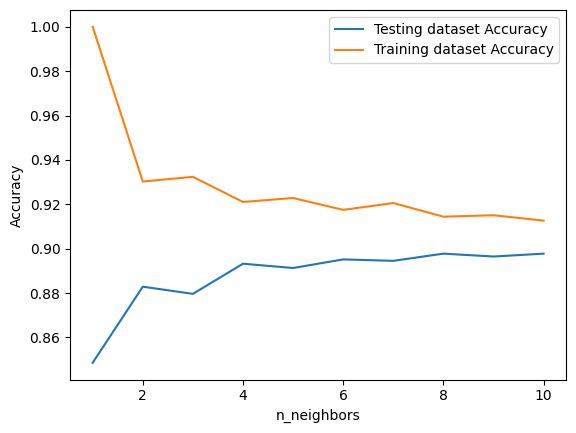

max accuracy: 0.8977346278317152


In [68]:
# testing many different neighbors
neighbors = np.arange(1, 11)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over K values
for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Compute training and test data accuracy
    train_accuracy[i] = knn.score(X_train, y_train)
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.plot(neighbors, test_accuracy, label = 'Testing dataset Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training dataset Accuracy')

plt.legend()
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.show()
print(f"max accuracy: {max(test_accuracy)}")

### Decision Tree

In [107]:
from sklearn.tree import DecisionTreeClassifier

DTree_Model = DecisionTreeClassifier(random_state=2025, class_weight="balanced")
DTree_Model.fit(X_train_glove, y_train)

# Make predictions
y_pred = DTree_Model.predict(X_test_glove)
# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92      1389
           1       0.20      0.17      0.18       156

    accuracy                           0.85      1545
   macro avg       0.56      0.55      0.55      1545
weighted avg       0.84      0.85      0.84      1545



### Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train a Random Forest classifier
RF_Model = RandomForestClassifier(n_estimators=50, random_state=2025, class_weight="balanced")
RF_Model.fit(X_train_glove, y_train)

# Make predictions
y_pred = RF_Model.predict(X_test_glove)

# Evaluate the model
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      1.00      0.95      1389
           1       0.54      0.04      0.08       156

    accuracy                           0.90      1545
   macro avg       0.72      0.52      0.51      1545
weighted avg       0.87      0.90      0.86      1545



### Naive Bayes

Accuracy: 72.69%


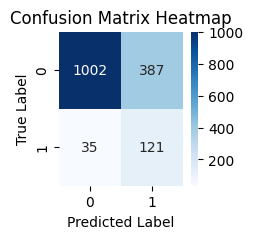


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.72      0.83      1389
           1       0.24      0.78      0.36       156

    accuracy                           0.73      1545
   macro avg       0.60      0.75      0.60      1545
weighted avg       0.89      0.73      0.78      1545



In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns

# # WORD2VEC normalizing weights to 0-1 bc NB doesn't take negative numbers
# from sklearn.preprocessing import MinMaxScaler 
# scaler = MinMaxScaler()
# X_train_pos = scaler.fit_transform(X_train)
# X_test_pos = scaler.transform(X_test)
# X_training_data = X_test_pos

# TFIDF 
vectorizer = TfidfVectorizer(
    stop_words='english', 
    # max_df=0.1,           # Ignore terms that appear in >20% of documents
    # min_df=3,             # Ignore terms that appear in fewer than 3 documents
    # ngram_range=(1, 2),   # Include bigrams (e.g., "tree density")
    max_features=10000)  # tune max_features if needed
# Fit on training data, transform both train and test
X_train_tfidf = vectorizer.fit_transform(X_train_og)
X_test_tfidf = vectorizer.transform(X_test_og)

X_training_data = X_train_tfidf
X_testing_data = X_test_tfidf

model = MultinomialNB()
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
model.fit(X_training_data, y_train, sample_weight=sample_weights)

y_pred = model.predict(X_testing_data)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy *100 :.2f}%')

class_labels = np.unique(y_test)

plt.figure(figsize=(2, 2))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
print("\nClassification Report:\n", classification_report(y_test, y_pred))

In [32]:
# To inspect influential words
import numpy as np

# Get class log probabilities for features
log_probs = model.feature_log_prob_

# For binary classification:
class0_words = np.argsort(log_probs[0])[::-1]
class1_words = np.argsort(log_probs[1])[::-1]

# Map indices to words
feature_names = vectorizer.get_feature_names_out()

print("Top words for class 0:")
class0_top_words = [feature_names[i] for i in class0_words[:30]]
print(class0_top_words)

print("Top words for class 1:")
class1_top_words = [feature_names[i] for i in class1_words[:30]]
print(class1_top_words)

Top words for class 0:
['soil', 'forest', 'carbon', 'species', 'restoration', 'biomass', 'tree', 'forests', 'land', 'vegetation', 'study', 'water', 'microbial', 'organic', 'ecosystem', 'different', 'natural', 'management', 'growth', 'climate', 'litter', 'effects', 'results', 'secondary', 'plantations', 'total', 'plant', 'use', 'tropical', 'using']
Top words for class 1:
['soil', 'carbon', 'biomass', 'forest', 'soc', 'tree', 'mg', 'stocks', 'organic', 'land', 'species', 'total', 'agroforestry', 'plantations', 'forests', 'stock', 'storage', 'sequestration', 'plantation', 'trees', 'aboveground', 'study', 'systems', 'secondary', 'microbial', 'use', 'different', 'stand', 'cm', 'years']


In [33]:
print("words in class 1 not in 0")
print(set(class1_top_words).difference(class0_top_words))
print("words in class 0 not in 1")
print(set(class0_top_words).difference(class1_top_words))

words in class 1 not in 0
{'cm', 'stocks', 'stand', 'mg', 'sequestration', 'systems', 'stock', 'plantation', 'storage', 'aboveground', 'years', 'trees', 'agroforestry', 'soc'}
words in class 0 not in 1
{'natural', 'water', 'growth', 'restoration', 'management', 'using', 'vegetation', 'effects', 'plant', 'litter', 'tropical', 'climate', 'ecosystem', 'results'}


In [139]:
for i, (pred, true) in enumerate(zip(y_pred, y_test)):
    if pred != true:
        print("Misclassified:")
        print(X_test.iloc[i])
        print(f"Predicted: {pred}, Actual: {true}")
        break

Misclassified:
A global meta-analysis of soil phosphorus dynamics after afforestation Afforestation significantly affects soil chemistry and biota, but its effects on the potentially growth-limiting nutrient phosphorus (P) had not to our knowledge been analyzed globally. We conducted a comprehensive meta-analysis of 220 independent sampling sites from 108 articles to evaluate global patterns and controls of soil P change following afforestation. Overall, total P concentration decreased by 11% and total P stock by 12% in the top 20 cm of mineral soil following afforestation, with no change in available P. Time since afforestation had no consistent effect on total P, while available P tended to increase with time. Prior land cover was the most influential factor for soil P change after afforestation, with available P increasing on native vegetation but decreasing on cropland. Afforestation increased available P by 22% without decreasing total P on formerly 'degraded' land, but depleted t

## Neural Networks

In [67]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

### RNN

In [118]:
from sklearn.model_selection import train_test_split

data = pd.read_csv("data/TAB_binaryLabel.csv")
data['tab_proc'] = data['TAB'].str.lower().str.split()

# label_encoder = LabelEncoder()
# data['relevant_proc'] = label_encoder.fit_transform(data['relevant'])

train_data, test_data = train_test_split(data[['tab_proc', 'label']], test_size=0.2, random_state=2025)

vocab = {word for phrase in data['tab_proc'] for word in phrase}
word_to_idx = {word: idx for idx, word in enumerate(vocab, start=1)}

max_length = data['tab_proc'].str.len().max()

def encode_and_pad(text):
    encoded = [word_to_idx[word] for word in text]
    return encoded + [0] * (max_length - len(encoded))

train_data['tab_proc'] = train_data['tab_proc'].apply(encode_and_pad)
test_data['tab_proc'] = test_data['tab_proc'].apply(encode_and_pad)

In [140]:
class RelevanceDataset(Dataset):
    def __init__(self, data):
        self.texts = data['tab_proc'].values
        self.labels = data['label'].values
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)

train_dataset = RelevanceDataset(train_data)
test_dataset = RelevanceDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [141]:
class RelevanceRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RelevanceRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

vocab_size = len(vocab) + 1
embed_size = 128
hidden_size = 128
output_size = 2 

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data["label"]), y=train_data["label"])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [142]:
class_weights

array([0.55227882, 5.28205128])

In [143]:
for inputs, labels in train_loader:
    print(labels)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 1, 0, 0,

In [145]:
from sklearn.metrics import precision_score, recall_score, f1_score

RNN_model = RelevanceRNN(vocab_size, embed_size, hidden_size, output_size)
optimizer = optim.Adam(RNN_model.parameters(), lr=0.0001)

num_epochs = 10
for epoch in range(num_epochs):
    RNN_model.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        texts = torch.LongTensor(texts)
        outputs = RNN_model(texts)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}')

    # get test metrics
    RNN_model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        preds = []
        truth = []
        for texts, labels in test_loader:
            outputs = RNN_model(texts)
            # _, predicted = torch.max(outputs.data, 1)
            _, predicted = torch.max(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            preds.extend(predicted.tolist())
            truth.extend(labels.tolist())
            
         # Calculate evaluation metrics
        accuracy = correct / total
        precision = precision_score(truth, preds)
        recall = recall_score(truth, preds)
        f1 = f1_score(truth, preds)

        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1-Score: {f1:.2f}")
    
    

Epoch [1/10], Loss: 0.6865


/Users/lauvav/miniconda3/envs/changlab310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.90
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
Epoch [2/10], Loss: 0.6852


/Users/lauvav/miniconda3/envs/changlab310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.90
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
Epoch [3/10], Loss: 0.6858


/Users/lauvav/miniconda3/envs/changlab310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.90
Precision: 0.00
Recall: 0.00
F1-Score: 0.00
Epoch [4/10], Loss: 0.6823


/Users/lauvav/miniconda3/envs/changlab310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Accuracy: 0.90
Precision: 0.00
Recall: 0.00
F1-Score: 0.00


KeyboardInterrupt: 

In [ ]:
# eval from lstm
# model.eval()
# with torch.no_grad():
#     total_test_samples = 0
#     correct_predictions = 0

#     predicted_labels_list = []
#     targets_list = []

#     for inputs, labels in test_loader:
#         inputs = torch.LongTensor(inputs)
#         targets = labels
#         outputs = model(inputs)

#         _, predicted_labels = torch.max(outputs, dim=1)

#         total_test_samples += len(inputs)
#         correct_predictions += (predicted_labels == targets).sum().item()

#         predicted_labels_list.extend(predicted_labels.tolist())
#         targets_list.extend(targets.tolist())

#     # Calculate evaluation metrics
#     accuracy = correct_predictions / total_test_samples
#     precision = precision_score(targets_list, predicted_labels_list)
#     recall = recall_score(targets_list, predicted_labels_list)
#     f1 = f1_score(targets_list, predicted_labels_list)

#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1-Score: {f1:.4f}")

Accuracy: 0.8414
Precision: 0.1608
Recall: 0.1554
F1-Score: 0.1581


In [ ]:
RNN_model.eval()
correct = 0
total = 0
preds = []
truth = []
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = RNN_model(texts)
        print(outputs[:10])
        _, predicted = torch.max(outputs.data, 1)
        print(f"torch.max(outputs.data, 1): {torch.max(outputs.data, 1)}")
        print(predicted[:5])
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        preds += predicted
        truth += labels
        break

# accuracy = 100 * correct / total
# print(f'Accuracy: {accuracy:.2f}%')
# print("\nClassification Report:\n", classification_report(truth, preds))


tensor([[ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102],
        [ 0.1060, -0.3102]])
torch.max(outputs.data, 1): torch.return_types.max(
values=tensor([0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060,
        0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060,
        0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060, 0.1060,
        0.1060, 0.1060, 0.1060, 0.1060, 0.1060]),
indices=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))
tensor([0, 0, 0, 0, 0])


### RNN 2

In [146]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import precision_score, recall_score, f1_score

# Load CSV with pandas
train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')

tokenizer = get_tokenizer('basic_english')

# Generator that yields token lists from the "TAB" column
def yield_tokens_from_df(df):
    for text in df['TAB']:
        yield tokenizer(str(text))  # convert to str in case of NaN or other types

# Build vocab with unknown token
vocab = build_vocab_from_iterator(yield_tokens_from_df(train_df), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [147]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, dataframe, vocab, tokenizer):
        self.df = dataframe
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]['TAB'])  # Ensure it's a string
        label = self.df.iloc[idx]['label']
        tokens = self.tokenizer(text)  # tokenizer expects a string
        numerical_tokens = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]
        return numerical_tokens, label

In [148]:
class RelevanceRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RelevanceRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

from torch.nn.utils.rnn import pad_sequence
def collate_batch(batch):
    inputs, labels = zip(*batch)
    inputs = [torch.tensor(x) for x in inputs]
    labels = torch.tensor(labels)
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    return padded_inputs, labels

In [149]:
# Training parameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 128
num_classes = 2
batch_size = 16
num_epochs = 10
learning_rate = 0.001

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data["label"]), y=train_data["label"])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Create the model
model = RelevanceRNN(vocab_size, embedding_dim, hidden_dim, num_classes)

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders for the training and validation sets
train_dataset = TextDataset(train_df, vocab, tokenizer)
test_dataset = TextDataset(test_df, vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [150]:

# Iterate over the training data for the specified number of epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0.0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = torch.LongTensor(inputs)
        targets = inputs.clone()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    avg_loss = total_loss / total_samples
    print(f"Train Loss: {avg_loss:.4f}")

    # Use the trained model to make predictions on the test set
    model.eval()
    with torch.no_grad():
        total_test_samples = 0
        correct_predictions = 0

        predicted_labels_list = []
        targets_list = []

        for inputs, labels in test_loader:
            inputs = torch.LongTensor(inputs)
            targets = labels
            outputs = model(inputs)

            _, predicted_labels = torch.max(outputs, dim=1)

            total_test_samples += len(inputs)
            correct_predictions += (predicted_labels == targets).sum().item()

            predicted_labels_list.extend(predicted_labels.tolist())
            targets_list.extend(targets.tolist())

        # Calculate evaluation metrics
        accuracy = correct_predictions / total_test_samples
        precision = precision_score(targets_list, predicted_labels_list)
        recall = recall_score(targets_list, predicted_labels_list)
        f1 = f1_score(targets_list, predicted_labels_list)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    # avg_val_loss = total_val_loss / total_val_samples

    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {avg_val_loss:.4f}")


Epoch 1/10
Train Loss: 0.7057
Accuracy: 0.9023
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Epoch 2/10
Train Loss: 0.6874
Accuracy: 0.8725
Precision: 0.1449
Recall: 0.0676
F1-Score: 0.0922
Epoch 3/10
Train Loss: 0.6886
Accuracy: 0.8906
Precision: 0.1111
Recall: 0.0203
F1-Score: 0.0343
Epoch 4/10
Train Loss: 0.6829
Accuracy: 0.8964
Precision: 0.2000
Recall: 0.0270
F1-Score: 0.0476
Epoch 5/10
Train Loss: 0.6831
Accuracy: 0.8932
Precision: 0.1600
Recall: 0.0270
F1-Score: 0.0462
Epoch 6/10
Train Loss: 0.7003
Accuracy: 0.8880
Precision: 0.1622
Recall: 0.0405
F1-Score: 0.0649
Epoch 7/10
Train Loss: 0.6977
Accuracy: 0.8712
Precision: 0.1304
Recall: 0.0608
F1-Score: 0.0829
Epoch 8/10
Train Loss: 0.6926
Accuracy: 0.8803
Precision: 0.1373
Recall: 0.0473
F1-Score: 0.0704
Epoch 9/10
Train Loss: 0.6918
Accuracy: 0.8790
Precision: 0.1321
Recall: 0.0473
F1-Score: 0.0697
Epoch 10/10
Train Loss: 0.6974
Accuracy: 0.8816
Precision: 0.1111
Recall: 0.0338
F1-Score: 0.0518


### LSTM

https://medium.com/@spandey8312/text-classification-using-custom-data-and-pytorch-d88ba1087045

In [ ]:
# import pandas as pd
# import torch
# from torch import nn
# from torch.utils.data import Dataset, DataLoader
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Assuming you have downloaded and extracted the WikiText2 dataset files
# train_file = 'data/train_data.csv'
# test_file = 'data/test_data.csv'

# # Tokenize the text data
# tokenizer = get_tokenizer('basic_english')

# # Build the vocabulary
# def build_vocab(file_path):
#     with open(file_path, 'r', encoding='utf-8') as f:
#         tokens = tokenizer(f.read())
#     return tokens

# train_tokens = build_vocab(train_file)
# vocab = build_vocab_from_iterator(train_tokens)

In [ ]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import precision_score, recall_score, f1_score

# Load CSV with pandas
train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')

tokenizer = get_tokenizer('basic_english')

# Generator that yields token lists from the "TAB" column
def yield_tokens_from_df(df):
    for text in df['TAB']:
        yield tokenizer(str(text))  # convert to str in case of NaN or other types

# Build vocab with unknown token
vocab = build_vocab_from_iterator(yield_tokens_from_df(train_df), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
# class RelevanceDataset(Dataset):
#     def __init__(self, data):
#         self.texts = data['tab_proc'].values
#         self.labels = data['label'].values
    
#     def __len__(self):
#         return len(self.texts)
    
#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]
#         return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)


In [79]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, dataframe, vocab, tokenizer):
        self.df = dataframe
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    # def __getitem__(self, idx):
    #     text = self.df['TAB'].values
    #     label = self.df['label'].values
    #     tokens = self.tokenizer(text)
    #     # numerical_tokens = [self.vocab[token] for token in tokens]
    #     numerical_tokens = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]
    #     return numerical_tokens, label
    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]['TAB'])  # Ensure it's a string
        label = self.df.iloc[idx]['label']
        tokens = self.tokenizer(text)  # tokenizer expects a string
        numerical_tokens = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]
        return numerical_tokens, label

In [65]:
# class TextDataset(Dataset):
#     def __init__(self, file_path, vocab, tokenizer):
#         self.vocab = vocab
#         self.tokenizer = tokenizer
#         self.data = pd.read_csv(file_path)
    
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         text = self.data.iloc[idx]['TAB']
#         label = self.data.iloc[idx]['label']
        
#         tokens = self.tokenizer(text)
#         numerical_tokens = [self.vocab[token] for token in tokens]
        
#         return numerical_tokens, label

In [66]:
# class TextDataset(Dataset):
#     def __init__(self, file_path, vocab):
#         self.data = self.load_data(file_path)
#         self.vocab = vocab
    
#     def load_data(self, file_path):
#         with open(file_path, 'r', encoding='utf-8') as f:
#             tokens = tokenizer(f.read())
#         return tokens
        
#     def __len__(self):
#         return len(self.data)
    
#     def __getitem__(self, idx):
#         example = self.data[idx]
#         # Convert the example into numerical representations using the vocabulary
#         numerical_tokens = [self.vocab[token] for token in example]
#         return numerical_tokens

In [80]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.rnn(embedded)
        last_hidden = output[:, -1, :]
        logits = self.fc(last_hidden)
        return logits

In [81]:
from torch.nn.utils.rnn import pad_sequence

def collate_batch(batch):
    inputs, labels = zip(*batch)
    inputs = [torch.tensor(x) for x in inputs]
    labels = torch.tensor(labels)
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    return padded_inputs, labels


In [82]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_df["label"]), y=train_df["label"])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
class_weights_tensor

tensor([0.5531, 5.2108])

In [110]:
# Training parameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 128
num_classes = 2
batch_size = 8
num_epochs = 10
learning_rate = 0.001

# Create the model
model = TextClassifier(vocab_size, embedding_dim, hidden_dim, num_classes)

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders for the training and validation sets
train_dataset = TextDataset(train_df, vocab, tokenizer)
test_dataset = TextDataset(test_df, vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [111]:
for batch in train_loader:
    print(batch[1])
    break

tensor([0, 1, 0, 0, 0, 0, 0, 0])


In [113]:

# Iterate over the training data for the specified number of epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0.0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = torch.LongTensor(inputs)
        targets = inputs.clone()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    avg_loss = total_loss / total_samples
    print(f"Train Loss: {avg_loss:.4f}")

    # # Evaluate on the validation set after every epoch
    # model.eval()
    # total_val_loss = 0.0
    # total_val_samples = 0
    # with torch.no_grad():
    #     for inputs in test_loader:
    #         inputs = torch.LongTensor(inputs)
    #         targets = inputs.clone()
    #         outputs = model(inputs)
    #         val_loss = criterion(outputs.view(-1, num_classes), targets.view(-1))

    #         total_val_loss += val_loss.item() * len(inputs)
    #         total_val_samples += len(inputs)


    # Use the trained model to make predictions on the test set
    model.eval()
    with torch.no_grad():
        total_test_samples = 0
        correct_predictions = 0

        predicted_labels_list = []
        targets_list = []

        for inputs, labels in test_loader:
            inputs = torch.LongTensor(inputs)
            targets = labels
            outputs = model(inputs)

            _, predicted_labels = torch.max(outputs, dim=1)

            total_test_samples += len(inputs)
            correct_predictions += (predicted_labels == targets).sum().item()

            predicted_labels_list.extend(predicted_labels.tolist())
            targets_list.extend(targets.tolist())

        # Calculate evaluation metrics
        accuracy = correct_predictions / total_test_samples
        precision = precision_score(targets_list, predicted_labels_list)
        recall = recall_score(targets_list, predicted_labels_list)
        f1 = f1_score(targets_list, predicted_labels_list)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    # avg_val_loss = total_val_loss / total_val_samples

    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {avg_val_loss:.4f}")


Epoch 1/10
Train Loss: 0.6195
Accuracy: 0.8958
Precision: 0.2174
Recall: 0.0338
F1-Score: 0.0585
Epoch 2/10
Train Loss: 0.6004
Accuracy: 0.8984
Precision: 0.2000
Recall: 0.0203
F1-Score: 0.0368
Epoch 3/10
Train Loss: 0.5642
Accuracy: 0.8272
Precision: 0.1210
Recall: 0.1284
F1-Score: 0.1246
Epoch 4/10
Train Loss: 0.4730
Accuracy: 0.7728
Precision: 0.1309
Recall: 0.2432
F1-Score: 0.1702
Epoch 5/10
Train Loss: 0.3536
Accuracy: 0.8350
Precision: 0.1259
Recall: 0.1216
F1-Score: 0.1237
Epoch 6/10
Train Loss: 0.2331
Accuracy: 0.8052
Precision: 0.1304
Recall: 0.1824
F1-Score: 0.1521
Epoch 7/10
Train Loss: 0.1547
Accuracy: 0.8026
Precision: 0.1416
Recall: 0.2095
F1-Score: 0.1689
Epoch 8/10
Train Loss: 0.1230
Accuracy: 0.8272
Precision: 0.1304
Recall: 0.1419
F1-Score: 0.1359
Epoch 9/10
Train Loss: 0.0796
Accuracy: 0.8479
Precision: 0.1628
Recall: 0.1419
F1-Score: 0.1516
Epoch 10/10
Train Loss: 0.0593
Accuracy: 0.8414
Precision: 0.1608
Recall: 0.1554
F1-Score: 0.1581


In [98]:
# Load the test set or a separate evaluation set
test_dataset = TextDataset(test_df, vocab, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

# Use the trained model to make predictions on the test set
model.eval()
with torch.no_grad():
    total_test_samples = 0
    correct_predictions = 0

    predicted_labels_list = []
    targets_list = []

    for inputs, labels in test_loader:
        inputs = torch.LongTensor(inputs)
        targets = labels
        outputs = model(inputs)
        print(f"OUTPUTS: {outputs}")

        _, predicted_labels = torch.max(outputs, dim=1)

        total_test_samples += len(inputs)
        correct_predictions += (predicted_labels == targets).sum().item()

        predicted_labels_list.extend(predicted_labels.tolist())
        targets_list.extend(targets.tolist())

    # Calculate evaluation metrics
    accuracy = correct_predictions / total_test_samples
    precision = precision_score(targets_list, predicted_labels_list)
    recall = recall_score(targets_list, predicted_labels_list)
    f1 = f1_score(targets_list, predicted_labels_list)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

OUTPUTS: tensor([[ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [-0.1802,  0.4610],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222]])
OUTPUTS: tensor([[ 0.7617, -0.6118],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222]])
OUTPUTS: tensor([[ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.4887, -0.1840],
        [ 0.3037, -0.1673],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222]])
OUTPUTS: tensor([[ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.3229, -0.2222],
        [ 0.7660, -0.3646]])
OUTPUTS: tensor([[ 0.3229, -0.2222],
        [ 0.3229, -0.2222],

### GRU

In [151]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from sklearn.metrics import precision_score, recall_score, f1_score

# Load CSV with pandas
train_df = pd.read_csv('data/train_data.csv')
test_df = pd.read_csv('data/test_data.csv')

tokenizer = get_tokenizer('basic_english')

# Generator that yields token lists from the "TAB" column
def yield_tokens_from_df(df):
    for text in df['TAB']:
        yield tokenizer(str(text))  # convert to str in case of NaN or other types

# Build vocab with unknown token
vocab = build_vocab_from_iterator(yield_tokens_from_df(train_df), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [152]:
from torch.utils.data import Dataset
class TextDataset(Dataset):
    def __init__(self, dataframe, vocab, tokenizer):
        self.df = dataframe
        self.vocab = vocab
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = str(self.df.iloc[idx]['TAB'])  # Ensure it's a string
        label = self.df.iloc[idx]['label']
        tokens = self.tokenizer(text)  # tokenizer expects a string
        numerical_tokens = [self.vocab[token] if token in self.vocab else self.vocab['<unk>'] for token in tokens]
        return numerical_tokens, label

from torch.nn.utils.rnn import pad_sequence
def collate_batch(batch):
    inputs, labels = zip(*batch)
    inputs = [torch.tensor(x) for x in inputs]
    labels = torch.tensor(labels)
    padded_inputs = pad_sequence(inputs, batch_first=True, padding_value=0)
    return padded_inputs, labels

In [ ]:
class RelevanceRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size):
        super(RelevanceRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [167]:
class RateGRU(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_units, batch_sz, output_size):
        super(RateGRU, self).__init__()
        self.batch = batch_sz
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_units = hidden_units
        self.output_size = output_size
        
        #layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_units, batch_first=True)
        self.fc = nn.Linear(self.hidden_units, self.output_size)
        
    # def initialize_hidden_state(self, device):
    #     return torch.zeros((1, self.batch, self.hidden_units)).to(device)
    
    # def forward(self, x, lens, device):
    def forward(self, x):
        x = self.embedding(x)
        # self.hidden = self.initialize_hidden_state()
        self.hidden = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        output, self.hidden = self.gru(x, self.hidden)
        # out = output[-1, :, :]
        out = output[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        
        return out

In [168]:
# Training parameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 128
num_classes = 2
batch_size = 16
num_epochs = 10
learning_rate = 0.001

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data["label"]), y=train_data["label"])
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Create the model
#               vocab_size, embedding_dim, hidden_units, batch_sz, output_size
model = RateGRU(vocab_size, embedding_dim, hidden_dim, batch_size, num_classes)

# Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders for the training and validation sets
train_dataset = TextDataset(train_df, vocab, tokenizer)
test_dataset = TextDataset(test_df, vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch)


In [169]:
# Iterate over the training data for the specified number of epochs
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    total_loss = 0.0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = torch.LongTensor(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(inputs)
        total_samples += len(inputs)

    avg_loss = total_loss / total_samples
    print(f"Train Loss: {avg_loss:.4f}")

    # Use the trained model to make predictions on the test set
    model.eval()
    with torch.no_grad():
        total_test_samples = 0
        correct_predictions = 0

        predicted_labels_list = []
        targets_list = []

        for inputs, labels in test_loader:
            inputs = torch.LongTensor(inputs)
            targets = labels
            outputs = model(inputs)

            _, predicted_labels = torch.max(outputs, dim=1)

            total_test_samples += len(inputs)
            correct_predictions += (predicted_labels == targets).sum().item()

            predicted_labels_list.extend(predicted_labels.tolist())
            targets_list.extend(targets.tolist())

        # Calculate evaluation metrics
        accuracy = correct_predictions / total_test_samples
        precision = precision_score(targets_list, predicted_labels_list)
        recall = recall_score(targets_list, predicted_labels_list)
        f1 = f1_score(targets_list, predicted_labels_list)

        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f}")

    # avg_val_loss = total_val_loss / total_val_samples

    # print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Test Loss: {avg_val_loss:.4f}")


Epoch 1/10
Train Loss: 0.7255
Accuracy: 0.8744
Precision: 0.0893
Recall: 0.0338
F1-Score: 0.0490
Epoch 2/10
Train Loss: 0.6980
Accuracy: 0.8913
Precision: 0.0455
Recall: 0.0068
F1-Score: 0.0118
Epoch 3/10
Train Loss: 0.6927
Accuracy: 0.8783
Precision: 0.1429
Recall: 0.0541
F1-Score: 0.0784
Epoch 4/10
Train Loss: 0.6677
Accuracy: 0.7799
Precision: 0.1522
Recall: 0.2838
F1-Score: 0.1981
Epoch 5/10
Train Loss: 0.5933
Accuracy: 0.7644
Precision: 0.1727
Recall: 0.3851
F1-Score: 0.2385
Epoch 6/10
Train Loss: 0.4624
Accuracy: 0.7540
Precision: 0.1723
Recall: 0.4122
F1-Score: 0.2430
Epoch 7/10
Train Loss: 0.3275
Accuracy: 0.8356
Precision: 0.1919
Recall: 0.2230
F1-Score: 0.2062
Epoch 8/10
Train Loss: 0.2046
Accuracy: 0.8142
Precision: 0.2043
Recall: 0.3243
F1-Score: 0.2507
Epoch 9/10
Train Loss: 0.1214
Accuracy: 0.8434
Precision: 0.1948
Recall: 0.2027
F1-Score: 0.1987
Epoch 10/10
Train Loss: 0.0698
Accuracy: 0.8395
Precision: 0.1951
Recall: 0.2162
F1-Score: 0.2051


## Transformers

### Hugging Face tutorial

In [ ]:
from datasets import load_dataset

data = load_dataset("csv", data_files="data/TAB_binaryLabel.csv", split='train')
data = data.train_test_split(test_size=0.2, seed=2025)
data

DatasetDict({
    train: Dataset({
        features: ['TAB', 'label'],
        num_rows: 6180
    })
    test: Dataset({
        features: ['TAB', 'label'],
        num_rows: 1545
    })
})

In [90]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["TAB"], truncation=True)

tokenized_datasets = data.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


Map: 100%|██████████| 1545/1545 [00:00<00:00, 4162.27 examples/s]


In [91]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['TAB', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 6180
    })
    test: Dataset({
        features: ['TAB', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1545
    })
})

In [92]:
tokenized_datasets = tokenized_datasets.remove_columns(["TAB"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names

['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [93]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=8, collate_fn=data_collator
)

In [94]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 473]),
 'token_type_ids': torch.Size([8, 473]),
 'attention_mask': torch.Size([8, 473])}

In [95]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [96]:
outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(0.6179, grad_fn=<NllLossBackward0>) torch.Size([8, 2])


In [97]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [98]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

2319


In [99]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device


device(type='cpu')

In [100]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 11/2319 [01:22<4:44:12,  7.39s/it]

KeyboardInterrupt: 

In [107]:
import evaluate

progress_bar = tqdm(range(len(eval_dataloader)))

precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")
accuracy = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    precision.add_batch(predictions=predictions, references=batch["labels"])
    recall.add_batch(predictions=predictions, references=batch["labels"])
    f1.add_batch(predictions=predictions, references=batch["labels"])
    accuracy.add_batch(predictions=predictions, references=batch["labels"])
    progress_bar.update(1)
    break

print(f"precision: {precision.compute()}")
print(f"recall: {recall.compute()}")
print(f"f1: {f1.compute()}")
print(f"accuracy: {accuracy.compute()}")


  1%|          | 1/194 [00:07<22:43,  7.07s/it]

precision: {'precision': 0.0}
recall: {'recall': 0.0}
f1: {'f1': 0.0}
accuracy: {'accuracy': 0.875}


/Users/lauvav/miniconda3/envs/changlab-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# EOF